# Project Milestone 03 (NE 591) - Serial neutron diffusion code
- **Author**: Kirill Shumilov
- **Date**: Fri, March 7, 2025

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

analysis_dir = pathlib.Path('.').absolute()
examples_dir = analysis_dir.parent / 'examples'
tests_dir = analysis_dir / 'tests'
executable = analysis_dir.parent / 'shumilov_project02'

# 1. Description of Work

In this milestone project, we compare the perfomance of direct (LU with Pivotiing) and iterative (Point-Jacobi, Gauss-Sedel, and Successive-over-Relaxation) methods when solving the system of linear equations in the form $Ax=b$, originating from finite-difference treatment of planar neutron diffusion equation. By variying the "size of the the problem," we attempt to understand how the parameters like the execution time, the consumed memory, the final absolute residual memory used to solve the problem depend on the said "size," and how those methods can be compared based on those parameters. Furthermore, we compare the iterative differ from LUP and how they differ from one another.

The "problem size" is understood as the rank, $n$, of the matrix $A$, i.e. how many elements exist in the matrix $N = n^2$. It is important to note that the matrices that we will be working with are strongly diagonally-dominant and very sparse. Specifically, they originate from the system of equations arising from the neutron diffusion equation on a planar rectangular region with uniformly spaced grid:
\begin{equation}
-D\left[\frac{\phi_{i+1,j}-2\phi_{i,j}+2\phi_{i+1,j}}{\delta^2} + \frac{\phi_{i,j-1}-2\phi_{i,j}+2\phi_{i,j + 1}}{\gamma^2}\right] + \Sigma_a\phi_{i,j} = q_{ij}
\end{equation}
where $D$ is the diffusion factor, $\Sigma_a$ - the macroscopic absorption cross-section, $q_{i,j}$ is the source strenght in the cell $(x_i,y_j)$, $\phi_{i,j}$ is the scalar flux in the cell $(x_i,y_j)$, and $\delta$ and $\gamma$ are the cell sizes in $x$ and $y$ respectively. This produces a matrix with only 5 non-zero diagonals.

The problem is solved differently, depending on the method used:
1) For LUP algorithm, a full matrix, $A$, is built. It is then factorized using LUP algorithm, $PA = LU$, where $P$ is permutation matrix, $L$ and $U$ are lower unit and upper matrices, respectively. The resulting system of equations, $LUx=Pb$, is then solved using forward and backward substitution.

2) For PJ, GS, and SOR algorithms, a full matrix is not used. Instead, a Sparse-Matrix vector routine is implemented that allows us to avoid storing and iterating over the zero elements of the matrix. Each respective algorithm kernel is applied iteratively to the guess of $x$ until absolute relative error ends up being below tolerance (or maximum number of iterations is acheived).
For Gauss Seidel ($\omega = 1$) and Successive-over-relaxation the following update equation is used, where $D$ is diagonal, $L$ strictly lower, and $U$ is strictly upper matrices constructed from $A$.
\begin{equation}
x^{(k+1)} = (1 - \omega) x^{(k)} + \omega D^{-1} (b - Lx^{(k + 1)} - Ux^{(k)})
\end{equation}
while for Point-Jacobe it is:
\begin{equation}
x^{(k+1)} = D^{-1} (b - Lx^{(k)} - Ux^{(k)})
\end{equation}
where $k$ denotes the iteration scheme.

# 2. Numerical Experiments

In [2]:
from utils import Grid, System, Parameters, Inputs
import numpy as np

In [23]:
grid_sizes = [8, 16, 32, 64, 128, 256, 512, 1024]

def generate_input_file(n: int) -> None:
    params = Parameters('pj', 1e-5, 500_000)
    # params = Parameters('lup')

    system = System.from_point_sources(
        Grid.build_square(10, n),
        locs=(2.5, 2.5),
        fwhms=1.0,
        D=1, S=0.1
    )
    
    # system = System.from_constant_source(
    #     Grid.build_square(10, n),
    #     D=1, S=0.1
    # )

    inputs = Inputs(params, system)

    filepath = tests_dir / f'g{n}_{params.algorithm}.inp'
    inputs.to_txt(filepath)

    return inputs


inputs = []
for n in grid_sizes:
    inp = generate_input_file(n)
    inputs.append(inp)

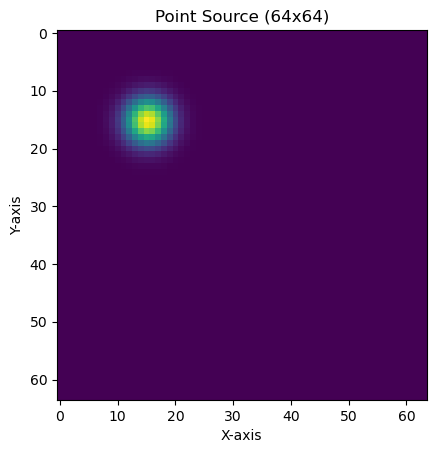

In [20]:
inp = inputs[0]
img = plt.imshow(inp.system.source, cmap='viridis')  # Use 'viridis' colormap
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

n = inp.system.grid.M
plt.title(f"Point Source ({n}x{n})")
plt.show()

To acheive the goal of the project, we selected six system with sizes $n=\{8, 16, 32, 59, 64, 70\}$, uniformly spaced grids and unit $D$, and $\Sigma_a$. The systems have a singular point source located in the top left corner of the rectangular region. The solutions, $\phi_{i,j}$ are shown above for each system. All iterative methods were allowd to run for maximum of $10000$ iterations with tolerance of $10^{-7}$ and relaxation fractor 1.905 (for SOR).

# 3. Results

Below is the table with the results of the calculations. Note that "converged" flag for LUP is set to "False", since there are no iterations done for this method.

In [11]:
df = pd.read_csv(tests_dir / 'data.csv', index_col=0)
df['time'] /= 1e3
df['memory'] /= 1024
df

,n,algo,residual,time,memory,converged,iterations,relative,relative_lup
0,8,lup,7.105427e-15,43.0,8849.3750,False,NaN,NaN,0.000000e+00
1,8,sor,2.890250e-07,872.0,8961.3750,True,185.0,7.293561e-08,1.014630e-09
2,8,gs,3.134093e-07,577.0,8977.4375,True,115.0,9.322245e-08,1.476089e-08
3,8,pj,3.956828e-07,1079.0,8801.4375,True,240.0,9.293805e-08,9.973211e-09
4,16,lup,1.175726e-13,1565.0,9825.4375,False,NaN,NaN,0.000000e+00
5,16,sor,3.511061e-07,3549.0,9009.4375,True,187.0,7.411481e-08,7.848531e-10
6,16,gs,1.495806e-06,7778.0,9105.3750,True,386.0,9.815953e-08,7.162751e-08
7,16,pj,2.256424e-06,14992.0,9073.4375,True,778.0,9.709612e-08,7.352970e-08
8,32,lup,6.252776e-13,114345.0,25345.5625,False,NaN,NaN,0.000000e+00
9,32,sor,9.743634e-07,14308.0,9089.3750,True,185.0,6.528925e-08,8.074249e-10


## Time, Memory, and Absolution Error

The graphs above show how, time in seconds, memory in kbytes, and maximum absolute residual, $r = b - Ax$, change for the four methods as a function of system size.

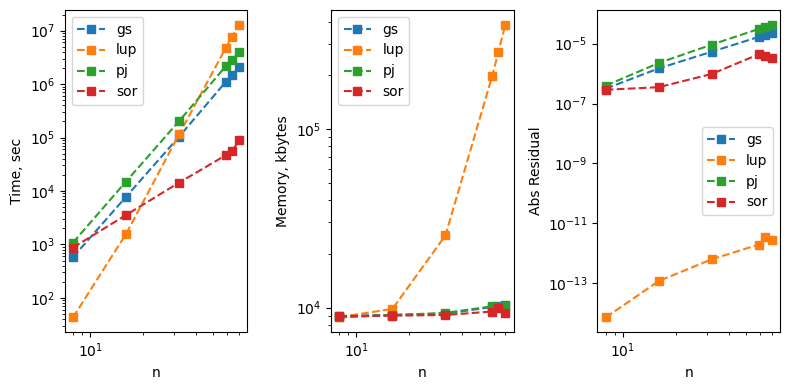

In [12]:
fig, axes = plt.subplots(1, 3, layout='tight', figsize=(8, 4))

for i, (algo, dfa) in enumerate(df.groupby('algo')):
    axes[0].loglog('n', 'time', 's--', data=dfa, label=algo) 
    axes[1].loglog('n', 'memory', 's--', data=dfa, label=algo)
    axes[2].loglog('n', 'residual', 's--', data=dfa, label=algo)

for ax in axes:
    ax.legend()
    ax.set_xlabel('n')

axes[0].set_ylabel('Time, sec')
axes[1].set_ylabel('Memory, kbytes')
axes[2].set_ylabel('Abs Residual')

plt.show()

Immediately we see that LUP methods provides the smallest absolute residual error of the four and thus can be treated as the "accuracy standard", where as all other iterative methods provide good to moderate absolute error. The error of these methods can be improved if allowe to run for more iterations. Finally, the absolute error growth with the size of the system is similar for the all methods.

In our case, the timing trends are similar for our all methods in the case of our particular system, aka it obeys a power law $O(n^k)$. It can be seen that, SOR has the smallest $k$, LUP has the largest $k$, while PJ and GS lie in between. The results indicated that had we run bigger sizes, LUP would have probably wouldn't have completed in time allocated.

The memeory used is the largest differentiator of the all the methods. The direct method, LUP, consumes markedly more memory than all other. For the three iterative solves the growth is essentially linear with $n$ as the only stored structures are the iterates, $x^k$ and the RHS vector $b$. For the LUP, it is the entire matrix A of size $n^2$.

## Number of iterations, Final relative error, and Error with respect to LUP

The graphs above show the number of iteratives, final relative error, $\text{max}|\frac{x^{(k+1)}_i}{x^{(k)}_i} - 1|$, and final relative error with respect to LUP for the iterative methods as a function of $n$.

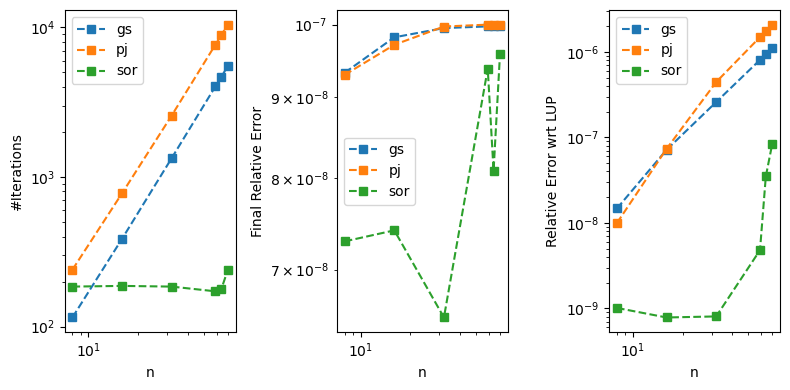

In [13]:
fig, axes = plt.subplots(1, 3, layout='tight', figsize=(8, 4))

for algo, dfa in df[df.algo != 'lup'].groupby('algo'):
    axes[0].loglog('n', 'iterations', 's--', data=dfa, label=algo)
    axes[1].loglog('n', 'relative', 's--', data=dfa, label=algo)
    axes[2].loglog('n', 'relative_lup', 's--', data=dfa, label=algo)

for ax in axes:
    ax.legend()
    ax.set_xlabel('n')

axes[0].set_ylabel('#Iterations')
axes[1].set_ylabel('Final Relative Error')
axes[2].set_ylabel('Relative Error wrt LUP')

plt.show()

As has been noted in the previous report:

Looking at the errors and number of iterations used for PJ, GS, and SOR we see expected behaviour. Number of iterations, Relative error (wrt to previous iterate), and relative error grows for PS and GS significantly in comparison to SOR. SOR is heavily dependent on relaxation factor (1.905 used here). However, even with suboptimal relaxation factor it outperforms all other algorithms. Notice, that Relative error ends up being smaller than relative error wrt to LUP, especially for PJ and GS. This is expected, as the convergence is slow for those to algorithms and change in guess vector becomes smaller much faster than the approach to the actual solution.

# 4. Discussion

As we see from the graphs below the key differentiator between direct and iterative methods are the time and memory scaling. While LUP provides better error "out-of-the-box" iterative schemes can match that with more iterations, given enough time. Furthermore, the iterative schemes are much better at utilizing the sparsity of the matrix, allowing to for much better memory characteristic. 

# 5. Conclusion

We have been able to show how different methods compare to one another. For small systems or where accuracy is of utmost importance LUP algorithm should be used. However, its memory and time scaling are not favorable and iterative schemes should be applied in most cases. Successive-over-relaxation shows to be the most robust of the three and allows for the best memory, time, and error scaling. It is the most practical methods of them all.